## Chapter 1.2: Data Structure and Manipulation
***
In the previous tutorial we saw how we can create a model by calling a few lines of code from imported data. However modelling tends to be an iterative process. Here we will explore the tools that `GemPy` with the help of `pandas` offers to modify the input data of a model.

There is 5 main  funtion "types" in GemPy:

- *create*: 
    - create new objects
    - return the objects
 
- *set*
    - set given values **inplace**

- *update*
    - update dataframe or other attribute from other object or many objects. Usually this object is not passed as argument (this is the main difference with map)

- *map*
    - update dataframe (so far mainly df) or other attribute from an object to another object.
    - Completelly directed. One attribute/property is updated by another one.
    - In general, we map_from so the method is in the mutated object.

- *get*
    - return an image of the object
    
The intention is that a function/method that does not fall in any of these categories has a name (verb in principle) self explanatory. 


As always we start importing the usual packages and reading expample data:

In [1]:
# from IPython.display import IFrame    
# IFrame("https://atlas.mindmup.com/2018/11/ca2c3230ddc511e887555f7d8bb30b4d/gempy_mind_map/index.html",
#       width=1000, height=1000)

In [2]:
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../..")

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import pandas as pn
import matplotlib.pyplot as plt


## Series

Series is the object that contains the properties associated with each independent scalar field. Right now it is simply the order of the series (which is infered by the index order). But in the future will be add the unconformity relation or perhaps the type of interpolator

Series and Faults classes are quite entagled since fauls are a type of series

In [3]:
faults = gp.Faults()
series = gp.Series(faults)
series.df

,order_series,BottomRelation
Default series,1,Erosion


We can modify the series bt using `set_series_index`:

In [4]:
series.set_series_index(['foo', 'foo2', 'foo5', 'foo7'])
series

,order_series,BottomRelation
foo,1,Erosion
foo2,2,Erosion
foo5,3,Erosion
foo7,4,Erosion


The index of series are pandas categories. These provides quite handy backend functionality (see pandas.Categorical).

In [5]:
series.df.index

CategoricalIndex(['foo', 'foo2', 'foo5', 'foo7'], categories=['foo', 'foo2', 'foo5', 'foo7'], ordered=False, dtype='category')

For adding new series:

In [6]:
series.add_series('foo3')
series

,order_series,BottomRelation
foo,1,Erosion
foo2,2,Erosion
foo5,3,Erosion
foo7,4,Erosion
foo3,5,Erosion


Delete series

In [7]:
series.delete_series('foo3')
series

,order_series,BottomRelation
foo,1,Erosion
foo2,2,Erosion
foo5,3,Erosion
foo7,4,Erosion


Rename series:

In [8]:
series.rename_series({'foo':'boo'})
series

,order_series,BottomRelation
boo,1,Erosion
foo2,2,Erosion
foo5,3,Erosion
foo7,4,Erosion


Reorder series:

In [9]:
series.reorder_series(['foo2', 'boo', 'foo7', 'foo5'])
series

,order_series,BottomRelation
foo2,1,Erosion
boo,2,Erosion
foo7,3,Erosion
foo5,4,Erosion


### Faults

The *df faults* is used to charectirize which *mathematical series* behave as fault and if mentioned faults are finite or infinite. Both df should get updated automatically as we modify the series object linked to the fault object (by passing it wehn a Series object is created).

In [10]:
faults

,isFault,isFinite
foo2,False,False
boo,False,NaN
foo7,False,NaN
foo5,False,NaN


Finally we have the *faults relations df* which captures which *mathematical series* a given fault offset in order to reproduce complex faulting networks

In [11]:
faults.faults_relations_df

,foo2,boo,foo7,foo5
foo2,False,False,False,False
boo,False,False,False,False
foo7,False,False,False,False
foo5,False,False,False,False


We can use `set_is_fault` to choose which of our series are faults:

In [12]:
faults.set_is_fault(['boo'])

,isFault,isFinite
foo2,False,False
boo,True,NaN
foo7,False,NaN
foo5,False,NaN


Similar thing for the fault relations:

In [13]:
fr = np.zeros((4, 4))
fr[2, 2] = True
faults.set_fault_relation(fr)

,foo2,boo,foo7,foo5
foo2,False,False,False,False
boo,False,False,False,False
foo7,False,False,True,False
foo5,False,False,False,False


Now if we change the series df and we update the series already defined will conserve their values while the new ones will be set to false:

In [14]:
series.add_series('foo20')


In [15]:
series

,order_series,BottomRelation
foo2,1,Erosion
boo,2,Erosion
foo7,3,Erosion
foo5,4,Erosion
foo20,5,Erosion


In [16]:
faults

,isFault,isFinite
foo2,False,False
boo,True,NaN
foo7,False,NaN
foo5,False,NaN
foo20,False,False


In [17]:
faults.faults_relations_df

,foo2,boo,foo7,foo5,foo20
foo2,False,False,False,False,False
boo,False,False,False,False,False
foo7,False,False,True,False,False
foo5,False,False,False,False,False
foo20,False,False,False,False,False


When we add new series the values switch  to NaN. We will be careful not having any nan in the DataFrames or we will raise errors down the line.

In [18]:
faults.set_is_fault()

,isFault,isFinite
foo2,False,False
boo,True,NaN
foo7,False,NaN
foo5,False,NaN
foo20,False,False


In [19]:
faults.set_fault_relation()

,foo2,boo,foo7,foo5,foo20
foo2,False,False,False,False,False
boo,False,False,False,False,False
foo7,False,False,False,False,False
foo5,False,False,False,False,False
foo20,False,False,False,False,False


### Formations:

The *df* formation contain three properties. *id* refers to the order of the formation on the sequential pile, i.e. the strict order of computation. *values* on the other hand is the final value that each voxel will have after discretization. This may be useful for example in the case we want to map a specific geophysical property (such as density) to a given unity. By default both are the same since to discretize lithological units the value is arbitrary.

#### From an empty df

The Formation class needs to have an associate series object. This will limit the name of the series since they are a pandas.Category

In [48]:
surfaces = gp.Surfaces(series)

We can set any number of formations by passing a list with the names. By default they will take the name or the first series.

In [49]:
surfaces.set_surfaces_names(['foo', 'foo2', 'foo5'])


True

In [50]:
series

,order_series,BottomRelation
foo2,1,Erosion
boo,2,Erosion
foo7,3,Erosion
foo5,4,Erosion
foo20,5,Erosion


We can add new formations:

In [23]:
surfaces.add_surface(['feeeee'])
surfaces

,surface,series,order_surfaces,isBasement,id
0,foo,foo20,1,False,1
1,foo2,foo20,2,False,2
2,foo5,foo20,3,False,3
3,feeeee,foo20,4,True,4


The column formation is also a pandas.Categories. This will be important for the Data clases (surface_points and Orientations)

In [55]:
surfaces.df['surface']

0     foo
1    foo2
2    foo5
Name: surface, dtype: object

In [56]:
surfaces.reorder_surfaces(['foo2', 'foo', 'foo5'])

In [58]:
surfaces

,surface,series,order_surfaces,isBasement,id
0,foo2,foo20,1,False,1
1,foo,foo20,2,False,2
2,foo5,foo20,3,True,3


### Set values

To set the values we do it with the following method

In [25]:
surfaces.set_surfaces_values([2,2,2,5])

True

In [26]:
surfaces

,surface,series,order_surfaces,isBasement,id,value_0
0,foo,foo20,1,False,1,2
1,foo2,foo20,2,False,2,2
2,foo5,foo20,3,False,3,2
3,feeeee,foo20,4,True,4,5


#### Set values with a given name:

We can give specific names to the properties (i.e. density)

In [27]:
surfaces.add_surfaces_values([[2,2,2,6], [2,2,1,8]], ['val_foo', 'val2_foo'])

True

In [28]:
surfaces

,surface,series,order_surfaces,isBasement,id,value_0,val_foo,val2_foo
0,foo,foo20,1,False,1,2,2,2
1,foo2,foo20,2,False,2,2,2,2
2,foo5,foo20,3,False,3,2,2,1
3,feeeee,foo20,4,True,4,5,6,8


### Delete formations values

To delete a full propery:

In [29]:
surfaces.delete_surface_values(['val_foo', 'value_0'])

True

#### One of the formations must be set be the basement:

In [30]:
surfaces.set_basement()
surfaces

,surface,series,order_surfaces,isBasement,id,val2_foo
0,foo,foo20,1,False,1,2
1,foo2,foo20,2,False,2,2
2,foo5,foo20,3,False,3,1
3,feeeee,foo20,4,True,4,8


#### Set formation values

We can also use set values instead adding. This will delete the previous properties and add the new one

In [31]:
surfaces.set_surfaces_values([[2,2,2,6], [2,2,1,8]], ['val_foo', 'val2_foo'])
surfaces

,surface,series,order_surfaces,isBasement,id,val_foo,val2_foo
0,foo,foo20,1,False,1,2,2
1,foo2,foo20,2,False,2,2,2
2,foo5,foo20,3,False,3,2,1
3,feeeee,foo20,4,True,4,6,8


The last property is the correspondant series that each formation belong to. `series` and `formation` are pandas categories. To get a overview of what this mean check https://pandas.pydata.org/pandas-docs/stable/categorical.html.

In [32]:
surfaces.df['series']

0    foo20
1    foo20
2    foo20
3    foo20
Name: series, dtype: category
Categories (5, object): [foo2, boo, foo7, foo5, foo20]

In [33]:
surfaces.df['surface']

0       foo
1      foo2
2      foo5
3    feeeee
Name: surface, dtype: object

### Map series to formation

To map a series to a formation we can do it by passing a dict:

In [34]:
surfaces

,surface,series,order_surfaces,isBasement,id,val_foo,val2_foo
0,foo,foo20,1,False,1,2,2
1,foo2,foo20,2,False,2,2,2
2,foo5,foo20,3,False,3,2,1
3,feeeee,foo20,4,True,4,6,8


In [35]:
series

,order_series,BottomRelation
foo2,1,Erosion
boo,2,Erosion
foo7,3,Erosion
foo5,4,Erosion
foo20,5,Erosion


If a series does not exist in the `Series` object, we rise a warning and we set those formations to nans

In [36]:
d =  {"foo7":'foo', "booX": ('foo2','foo5', 'fee')}

In [37]:
surfaces.map_series(d)

In [38]:
surfaces.map_series({"foo7":'foo', "boo": ('foo2','foo5', 'fee')})

In [39]:
surfaces

,surface,series,order_surfaces,isBasement,id,val_foo,val2_foo
1,foo2,boo,1,False,1,2,2
2,foo5,boo,2,False,2,2,1
0,foo,foo7,1,False,3,2,2
3,feeeee,foo20,1,True,4,6,8


An advantage of categories is that they are order so no we can tidy the df by series and formation

### Modify formation name

In [40]:
surfaces.rename_surfaces({'foo2':'lala'})

True

In [41]:
surfaces

,surface,series,order_surfaces,isBasement,id,val_foo,val2_foo
1,lala,boo,1,False,1,2,2
2,foo5,boo,2,False,2,2,1
0,foo,foo7,1,False,3,2,2
3,feeeee,foo20,1,True,4,6,8


In [42]:
surfaces.df.loc[2, 'val_foo'] = 22

In [43]:
surfaces

,surface,series,order_surfaces,isBasement,id,val_foo,val2_foo
1,lala,boo,1,False,1,2,2
2,foo5,boo,2,False,2,22,1
0,foo,foo7,1,False,3,2,2
3,feeeee,foo20,1,True,4,6,8


In [44]:
surfaces.update_sequential_pile()

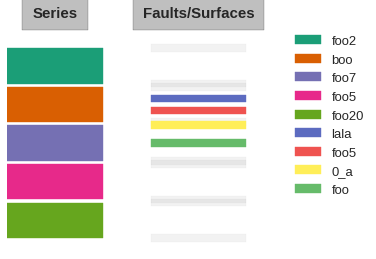

In [45]:
surfaces.sequential_pile.figure

# Data
#### surface_points
These two DataFrames (df from now on) will contain the individual information of each point at an interface or orientation. Some properties of this table are mapped from the *df* below.

In [46]:
surface_points = gp.surface_points(surfaces)
#orientations = gp.Orientations()

AttributeError: module 'gempy' has no attribute 'surface_points'

In [ ]:
surface_points

In [ ]:
surface_points.set_surface_points(pn.DataFrame(np.random.rand(6,3)), ['foo', 'foo5', 'lala', 'foo5', 'lala', 'feeeee'])

In [ ]:
surface_points

In [ ]:
surface_points.map_data_from_surfaces(surfaces, 'series')
surface_points

In [ ]:
surface_points.map_data_from_surfaces(surfaces, 'id')
surface_points

In [ ]:
series

In [ ]:
surface_points.map_data_from_series(series, 'order_series')
surface_points

In [ ]:
surface_points.sort_table()
surface_points

In [ ]:
faults

### Orientations

In [ ]:
orientations = gp.Orientations(surfaces)

In [ ]:
orientations

### Set values passing pole vectors:

In [ ]:
orientations.set_orientations(np.random.rand(6,3)*10,
                            np.random.rand(6,3),
                            surface=['foo', 'foo5', 'lala', 'foo5', 'lala', 'feeeee'])

In [ ]:
orientations

### Set values pasing orientation data: azimuth, dip, pole (dip direction)

In [ ]:
orientations.set_orientations(np.random.rand(6,3)*10,
                            orientation = np.random.rand(6,3)*20,
                            surface=['foo', 'foo5', 'lala', 'foo5', 'lala', 'feeeee'])

In [ ]:
orientations

### Mapping data from the other df

In [ ]:
orientations.map_data_from_surfaces(surfaces, 'series')
orientations

In [ ]:
orientations.map_data_from_surfaces(surfaces, 'id')
orientations

In [ ]:
orientations.map_data_from_series(series, 'order_series')
orientations

In [ ]:
orientations.set_annotations()

### Grid

In [ ]:
grid = gp.Grid()
grid.set_regular_grid([0,10,0,10,0,10], [50,50,50])

In [ ]:
grid.values

#### Rescaling Data

In [ ]:
rescaling = gp.RescaledData(surface_points, orientations, grid)


In [ ]:
surface_points

In [ ]:
orientations

### Additional Data

In [ ]:
ad = gp.AdditionalData(surface_points, orientations, grid, faults, surfaces, rescaling)


In [ ]:
ad

In [ ]:
ad.structure_data

In [ ]:
ad.options

In [ ]:
ad.options.df

In [ ]:
ad.options.df.dtypes

In [ ]:
ad.kriging_data

In [ ]:
ad.rescaling_data

### Interpolator

In [ ]:
interp = gp.Interpolator(surface_points, orientations, grid, f, faults, ad)

In [ ]:
# interp.compile_th_fn()